# __[ LG Energy Solution ] <br><br>Anomaly Detection Part1: Gauss, MoG, Parzen Window__

# <br>__1. Data: NASA Bearing Dataset__

In [ ]:
# github에서 데이터 불러오기
!git clone https://github.com/hj-choi-95/Anomaly_Detection_Part1.git

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

### Step1. 데이터 불러오기

In [2]:
# 데이터 불러오기
data = pd.read_csv('/content/Anomaly_Detection_Part1/data/nasa_bearing_dataset.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4,anomaly,data_type
2004-02-12 10:32:39,0.058332,0.071832,0.083244,0.043065,0,train
2004-02-12 10:42:39,0.058997,0.074008,0.084439,0.044540,0,train
2004-02-12 10:52:39,0.060239,0.074223,0.083922,0.044442,0,train
2004-02-12 11:02:39,0.061453,0.073843,0.084462,0.045081,0,train
2004-02-12 11:12:39,0.061361,0.075606,0.082837,0.045118,0,train


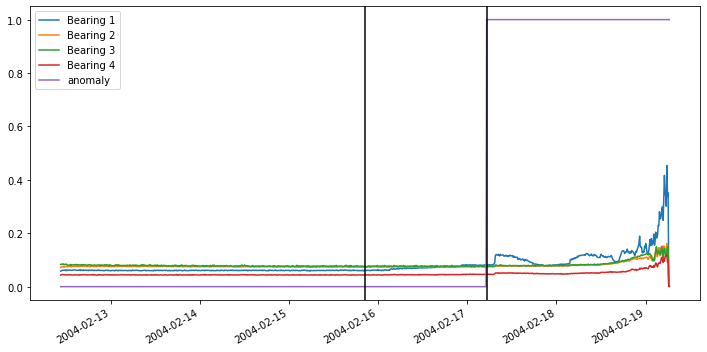

In [3]:
# 전체 기간의 데이터 분포 확인
data.plot(figsize = (12, 6))
plt.axvline(data.index[int(len(data) * 0.5)], c='black')
plt.axvline(data.index[int(len(data) * 0.7)], c='black')

### Step2. 데이터 Split

In [4]:
X_train = data[data['data_type'] == 'train'].iloc[:, :4]
y_train = data[data['data_type'] == 'train'].iloc[:, -2].values

X_test = data[data['data_type'] == 'test'].iloc[:, :4]
y_test = data[data['data_type'] == 'test'].iloc[:, -2].values

print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (492, 4)
Test data shape: (492, 4)


---

# __2. Gaussian Density Estimation__

### Gaussian Density Estimation
>모든 데이터가 하나의 가우시안(정규) 분포로부터 생성됨을 가정 <br>
>학습: 주어진 정상 데이터들을 통해 가우시안 분포의 평균 벡터와 공분산 행렬을 추정 <br>
>테스트: 새로운 데이터에 대하여 생성 확률을 구하고 이 확률이 낮을수록 이상치에 가까운 것으로 판정함

<img src="https://i.imgur.com/e9omVxY.jpg" width="800">

In [5]:
import math
import seaborn as sns
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, f1_score

### Step 1. Train 데이터 기반 분포 추정

In [6]:
# 가우시안 분포 추정 함수
def estimate_gaussian(dataset, cov_type):
    mu = np.mean(dataset, axis=0).values
    
    if cov_type == 'full': # Full Covariance matrix
        sigma = np.cov(dataset.T, bias=True)
    elif cov_type == 'diagonal': # Diagonal Covariance matrix
        sigma = np.cov(dataset.T, bias=True)
        sigma = np.diag(np.diag(sigma))
    elif cov_type == 'spherical': # Spherical Covariance matrix
        sigma = np.identity(dataset.shape[-1])
        
    return mu, sigma

In [7]:
mu, sigma = estimate_gaussian(X_train, cov_type='full')

print('Dimension of mu:', mu.shape)
print('Dimension of sigma:', sigma.shape)

Dimension of mu: (4,)
Dimension of sigma: (4, 4)


### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [8]:
# 다변량 가우시안 분포에서 -logpdf를 반환하는 함수
def multivariate_gaussian(dataset, mu, sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return - 1.0 * p.logpdf(dataset)

In [9]:
# train/test 데이터의 -logpdf 값 도출
gauss_train = multivariate_gaussian(X_train, mu, sigma)
gauss_test = multivariate_gaussian(X_test, mu, sigma)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

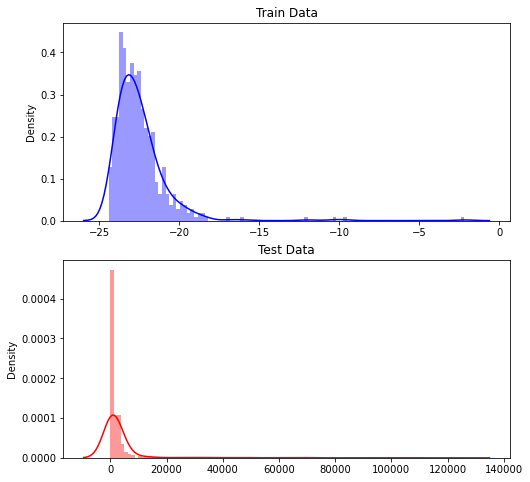

In [10]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(gauss_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(gauss_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [11]:
# threshold 탐색
# score의 min ~ max 범위를 num_step개로 균등 분할한 threshold에 대하여 best threshold 탐색 
def search_best_threshold(score, y_true, num_step):
    best_f1 = 0
    best_threshold = None
    for threshold in np.linspace(min(score), max(score), num_step):
        y_pred = threshold < score

        f1 = f1_score(y_true, y_pred)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold

    print('Best threshold: ', round(best_threshold, 4))
    print('Best F1 Score:', round(best_f1, 4))
    return best_threshold

In [12]:
# best threshold 도출
gauss_best_threshold = search_best_threshold(gauss_test, y_test, num_step=1000)

Best threshold:  227.1278
Best F1 Score: 0.925


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [13]:
# 최종 결과 도출
gauss_scores = pd.DataFrame(index=data.index)
gauss_scores['score'] = list(np.hstack([gauss_train, gauss_test]))
gauss_scores['anomaly'] = gauss_best_threshold < gauss_scores['score']
gauss_scores.head()

,score,anomaly
2004-02-12 10:32:39,-2.178153,False
2004-02-12 10:42:39,-10.353185,False
2004-02-12 10:52:39,-16.046509,False
2004-02-12 11:02:39,-11.969694,False
2004-02-12 11:12:39,-20.151358,False


In [14]:
# anomaly score plot 도출
def draw_plot(scores, threshold):
    normal_scores = scores[scores['anomaly'] == False]
    abnormal_scores = scores[scores['anomaly'] == True]

    plt.figure(figsize = (12,5))
    plt.scatter(normal_scores.index, normal_scores['score'], label='Normal', c='blue', s=3)
    plt.scatter(abnormal_scores.index, abnormal_scores['score'], label='Abnormal', c='red', s=3)
    
    plt.axhline(threshold, c='green', alpha=0.7)
    plt.axvline(data.index[int(len(data) * 0.5)], c='orange', ls='--')
    plt.axvline(data.index[int(len(data) * 0.7)], c='orange', ls='--')
    
    plt.xlabel('Date')
    plt.ylabel('Anomaly Score')
    plt.legend()
    
    plt.show()

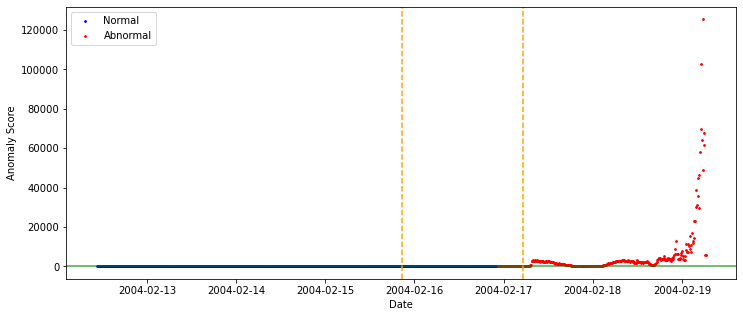

In [15]:
# 전체 데이터의 anomaly score 확인
draw_plot(gauss_scores, gauss_best_threshold)

In [16]:
# FRR, FAR, F1 score 도출
def calculate_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[True, False])
    tp, fn, fp, tn = cm.ravel()
    
    frr = fp / (fp + tn)
    far = fn / (fn + tp) 
    
    f1 = f1_score(y_true, y_pred)
    
    return frr, far, f1

In [17]:
# F1 Score: 0.9250
frr, far, f1 = calculate_metric(y_test, gauss_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2092  |  FAR: 0.0203  |  F1 Score: 0.925


### Step 5. 공분산행렬 조건에 따른 모델 성능 비교

In [18]:
# 가우시안 분포 기반 이상치 탐지 결과 도출 함수
def get_Gauss_result(X_train, X_test, y_test, cov_type_list, num_step):
    gauss_result = []
    for cov_type in cov_type_list:
        print('\n** Gauss Anomaly Detection with Covariance Type({})'.format(cov_type))
        
        # 가우시안 분포 추정
        mu, sigma = estimate_gaussian(X_train, cov_type=cov_type)

        # test 데이터의 -logpdf 값 도출
        gauss_test = multivariate_gaussian(X_test, mu, sigma)

        # best threshold 탐색
        gauss_best_threshold = search_best_threshold(gauss_test, y_test, num_step=num_step)

        # best threshold 기반 anomaly 여부 예측
        y_pred = gauss_best_threshold < gauss_test

        # # FRR, FAR, F1 score 도출
        frr, far, f1 = calculate_metric(y_test, y_pred)

        # 결과 축적
        gauss_result.append([cov_type, frr, far, f1])
    
    gauss_result = pd.DataFrame(gauss_result, columns=['cov_type', 'frr', 'far', 'f1'])
    return gauss_result

In [19]:
# Covariance matrix 조건에 따른 이상치 탐지 성능 비교
cov_type_list = ['full', 'diagonal', 'spherical']
gauss_result = get_Gauss_result(X_train, X_test, y_test, cov_type_list, num_step=1000)


** Gauss Anomaly Detection with Covariance Type(full)
Best threshold:  227.1278
Best F1 Score: 0.925

** Gauss Anomaly Detection with Covariance Type(diagonal)
Best threshold:  246.7128
Best F1 Score: 0.934

** Gauss Anomaly Detection with Covariance Type(spherical)
Best threshold:  3.6759
Best F1 Score: 0.929


In [20]:
# covariance_type=diag 일 때, F1 Score 기준 가장 좋은 성능을 도출함
gauss_result

,cov_type,frr,far,f1
0,full,0.209184,0.020270,0.925040
1,diagonal,0.178571,0.020270,0.933977
2,spherical,0.183673,0.027027,0.929032


---

# __<br> 3. Mixture of Gaussian (MoG) Density Estimation__

### Mixture of Gaussian (MoG) Density Estimation
>데이터가 **여러 개의 가우시안(정규) 분포의 혼합**으로 이루어져 있음을 허용하며, 여러 가우시안 분포들의 선형 결합으로 전체 데이터의 분포를 표현 <br>
>학습: 주어진 정상 데이터들을 통해 여러 가우시안 분포의 평균 벡터와 공분산 행렬 및 선형 가중치를 추정 <br>
>테스트: 새로운 데이터에 대하여 생성 확률을 구하고 이 확률이 낮을수록 이상치에 가까운 것으로 판정함

In [21]:
from sklearn import mixture

### Step 1. Train 데이터 기반 분포 추정

- GaussianMixture 설명
    - n_components: 가우시안 분포 개수. 디폴트 1
    - covariance_type: 공분산 유형 ('full', 'tied', 'diag', 'spherical'). 디폴트 'full'
    - max_iter: EM 알고리즘 수행 횟수. 디폴트 100

In [22]:
# MoG 분포 추정
gm_model = mixture.GaussianMixture(n_components=3, covariance_type='full', random_state=42)
gm_model.fit(X_train)

GaussianMixture(n_components=3, random_state=42)

In [23]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 평균
gm_model.means_

array([[0.06074298, 0.07468026, 0.07765413, 0.04398526],
       [0.06096395, 0.07524493, 0.0809079 , 0.04416257],
       [0.06086013, 0.07500927, 0.07853608, 0.04404562]])

In [24]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 공분산
gm_model.covariances_

array([[[ 1.58785623e-06,  1.81744893e-07,  2.72078515e-07,
          1.07839396e-07],
        [ 1.81744893e-07,  1.88561976e-06,  9.36925096e-07,
          1.21823060e-07],
        [ 2.72078515e-07,  9.36925096e-07,  3.57535741e-06,
          1.47443696e-07],
        [ 1.07839396e-07,  1.21823060e-07,  1.47443696e-07,
          1.24787763e-06]],

       [[ 1.93483732e-06,  4.57959149e-07,  4.93010804e-08,
          1.76454137e-07],
        [ 4.57959149e-07,  2.17606869e-06, -2.58404315e-07,
          1.30241988e-07],
        [ 4.93010804e-08, -2.58404315e-07,  6.14116004e-06,
          2.17951996e-07],
        [ 1.76454137e-07,  1.30241988e-07,  2.17951996e-07,
          1.28257141e-06]],

       [[ 1.63292370e-06,  2.34074302e-07,  4.94112489e-07,
          1.24355614e-07],
        [ 2.34074302e-07,  1.96336597e-06,  1.30331209e-06,
          1.40422032e-07],
        [ 4.94112489e-07,  1.30331209e-06,  5.01042119e-06,
          2.33290476e-07],
        [ 1.24355614e-07,  1.40422032e-

In [25]:
# 추정된 혼합 가우시안 분포를 구성하는 각 가우시안 분포의 가중치
gm_model.weights_

array([0.39776433, 0.07287772, 0.52935795])

### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [26]:
# train/test 데이터의 -logpdf 도출
gm_train = - 1.0 * gm_model.score_samples(X_train)
gm_test = - 1.0 * gm_model.score_samples(X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

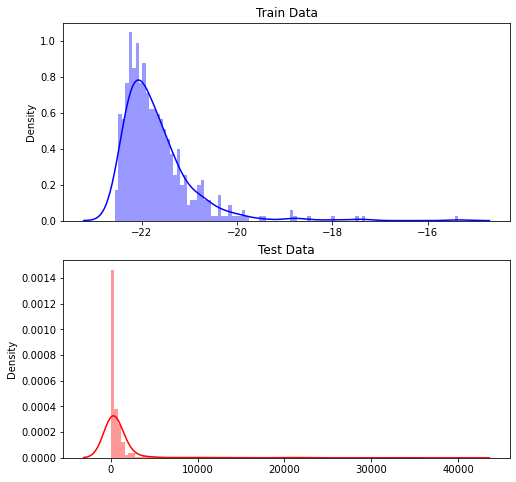

In [27]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(gm_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(gm_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [28]:
# best threshold 도출
gm_best_threshold = search_best_threshold(gm_test, y_test, num_step=1000)

Best threshold:  58.785
Best F1 Score: 0.9268


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [29]:
# 최종 결과 도출
gm_scores = pd.DataFrame(index=data.index)
gm_scores['score'] = list(np.hstack([gm_train, gm_test]))
gm_scores['anomaly'] = gm_best_threshold < gm_scores['score']
gm_scores.head()

,score,anomaly
2004-02-12 10:32:39,-15.366334,False
2004-02-12 10:42:39,-17.475645,False
2004-02-12 10:52:39,-18.826183,False
2004-02-12 11:02:39,-17.961375,False
2004-02-12 11:12:39,-20.166325,False


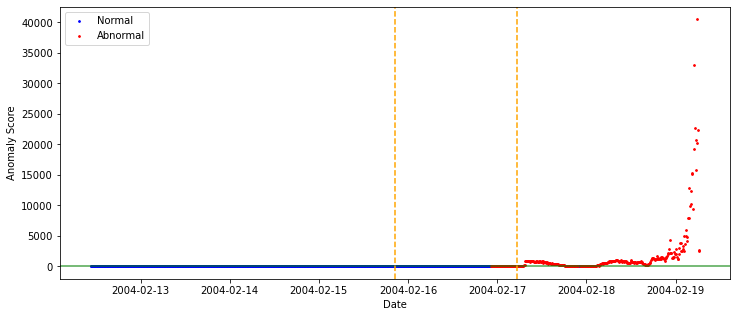

In [30]:
# 전체 데이터의 anomaly score 확인
draw_plot(gm_scores, gm_best_threshold)

In [31]:
# F1 Score: 0.9268
frr, far, f1 = calculate_metric(y_test, gm_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.2092  |  FAR: 0.0169  |  F1 Score: 0.9268


### Step 5. 공분산행렬 조건 및 가우시안 분포 개수에 따른 모델 성능 비교

In [32]:
# MoG 분포 기반 이상치 탐지 결과 도출 함수
def get_MoG_result(X_train, X_test, y_test, cov_type_list, n_comp_list, num_step):
    gm_result = []
    for cov_type in cov_type_list:
        for n_comp in n_comp_list:
            print('\n** MoG Anomaly Detection with Covariance Type({}) & # of Gauss({})'
                  .format(cov_type, n_comp))
    
            # MoG 분포 추정
            gm_model = mixture.GaussianMixture(n_components=n_comp,
                                               covariance_type=cov_type, random_state=42)
            gm_model.fit(X_train)

            # test 데이터의 -logpdf 도출
            gm_test = - 1.0 * gm_model.score_samples(X_test)

            # best threshold 탐색
            gm_best_threshold = search_best_threshold(gm_test, y_test, num_step=1000)

            # best threshold 기반 anomaly 여부 예측
            y_pred = gm_best_threshold < gm_test

            # # FRR, FAR, F1 score 도출
            frr, far, f1 = calculate_metric(y_test, y_pred)
            
            # 결과 축적
            gm_result.append([cov_type, n_comp, frr, far, f1])
    
    gm_result = pd.DataFrame(gm_result, columns=['cov_type', 'n_comp', 'frr', 'far', 'f1'])
    return gm_result

In [33]:
# Covariance matrix 조건 및 가우시안 분포 개수에 따른 이상치 탐지 성능 도출 함수
cov_type_list = ['full', 'diag', 'spherical']
n_comp_list = [3, 5, 7]
gm_result = get_MoG_result(X_train, X_test, y_test, cov_type_list, n_comp_list, num_step=1000)


** MoG Anomaly Detection with Covariance Type(full) & # of Gauss(3)
Best threshold:  58.785
Best F1 Score: 0.9268

** MoG Anomaly Detection with Covariance Type(full) & # of Gauss(5)
Best threshold:  64.1259
Best F1 Score: 0.9233

** MoG Anomaly Detection with Covariance Type(full) & # of Gauss(7)
Best threshold:  35.7336
Best F1 Score: 0.9091

** MoG Anomaly Detection with Covariance Type(diag) & # of Gauss(3)
Best threshold:  79.3945
Best F1 Score: 0.929

** MoG Anomaly Detection with Covariance Type(diag) & # of Gauss(5)
Best threshold:  79.1566
Best F1 Score: 0.929

** MoG Anomaly Detection with Covariance Type(diag) & # of Gauss(7)
Best threshold:  43.4494
Best F1 Score: 0.9335

** MoG Anomaly Detection with Covariance Type(spherical) & # of Gauss(3)
Best threshold:  66.8335
Best F1 Score: 0.926

** MoG Anomaly Detection with Covariance Type(spherical) & # of Gauss(5)
Best threshold:  58.1095
Best F1 Score: 0.9295

** MoG Anomaly Detection with Covariance Type(spherical) & # of G

In [34]:
# covariance_type=diag, n_components=7 일 때, F1 Score 기준 가장 좋은 성능을 도출함
gm_result

,cov_type,n_comp,frr,far,f1
0,full,3,0.209184,0.016892,0.926752
1,full,5,0.209184,0.023649,0.923323
2,full,7,0.295918,0.003378,0.909091
3,diag,3,0.183673,0.027027,0.929032
4,diag,5,0.183673,0.027027,0.929032
5,diag,7,0.209184,0.003378,0.933544
6,spherical,3,0.193878,0.027027,0.926045
7,spherical,5,0.193878,0.020270,0.929487
8,spherical,7,0.209184,0.010135,0.930159


---

# __<br> 4. Parzen Window__

### Kernel Density Estimation (Parzen Window)
>데이터가 특정한 분포를 갖는다는 가정없이 주어진 데이터로부터 주변부의 밀도를 추정하는 방식

In [35]:
from sklearn.neighbors import KernelDensity

### Step 1. Train 데이터 기반 분포 추정

- KernelDensity 설명
    - kernel: 사용할 커널 종류 ('gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine'). 디폴트 'gaussian'
    - bandwidth: smoothing 파라미터. 디폴트 1

In [36]:
# Parzen Window 분포 추정
kde_model = KernelDensity(kernel='gaussian', bandwidth=1)
kde_model.fit(X_train)

KernelDensity(bandwidth=1)

### Step 2. 추정된 분포를 기반으로 train/test 데이터의 anomaly score 도출

In [37]:
# train/test 데이터의 -logpdf 도출
kde_train = - 1.0 * kde_model.score_samples(X_train)
kde_test = - 1.0 * kde_model.score_samples(X_test)

/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/Users/heejeongchoi/miniconda3/envs/dsba/lib/python3.6/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Test Data')

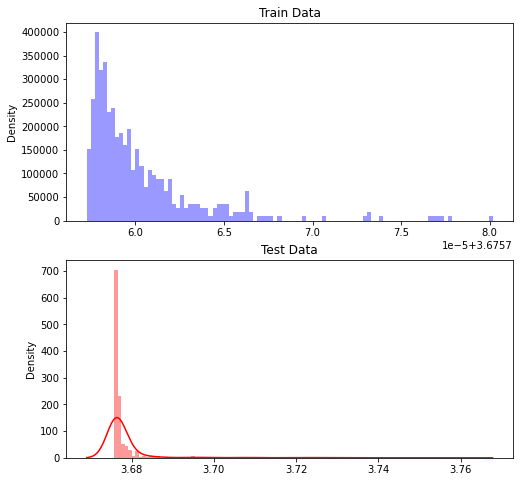

In [38]:
# train/test 데이터의 anomaly score 분포 시각화
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize = (8, 8))

sns.distplot(kde_train, bins=100, kde=True, color='blue', ax=ax1)
sns.distplot(kde_test, bins=100, kde=True, color='red', ax=ax2)
ax1.set_title("Train Data")
ax2.set_title("Test Data")

### Step 3. Threshold 탐색

In [39]:
# best threshold 탐색
kde_best_threshold = search_best_threshold(kde_test, y_test, num_step=1000)

Best threshold:  3.6759
Best F1 Score: 0.929


### Step 4. Best threshold를 기반으로 이상치 탐지 모형 평가

In [40]:
# 최종 결과 도출
kde_scores = pd.DataFrame(index=data.index)
kde_scores['score'] = list(np.hstack([kde_train, kde_test]))
kde_scores['anomaly'] = kde_best_threshold < kde_scores['score']
kde_scores.head()

,score,anomaly
2004-02-12 10:32:39,3.675777,False
2004-02-12 10:42:39,3.675778,False
2004-02-12 10:52:39,3.675773,False
2004-02-12 11:02:39,3.675777,False
2004-02-12 11:12:39,3.675768,False


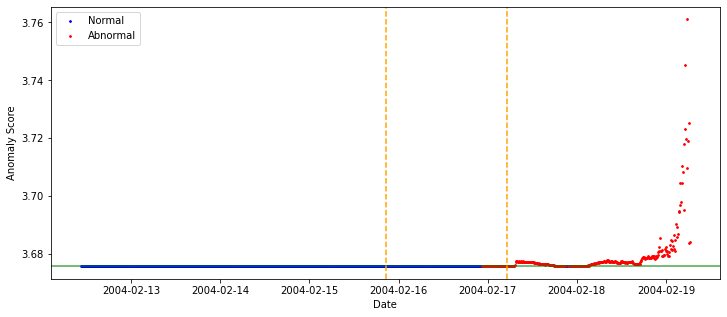

In [41]:
# 전체 데이터의 anomaly score 확인
draw_plot(kde_scores, kde_best_threshold)

In [42]:
# F1 Score: 0.9290
frr, far, f1 = calculate_metric(y_test, kde_scores['anomaly'].iloc[int(len(data) * 0.5):])

print("**  FRR: {}  |  FAR: {}  |  F1 Score: {}".format(round(frr, 4), round(far, 4), round(f1, 4)))

**  FRR: 0.1837  |  FAR: 0.027  |  F1 Score: 0.929


### Step 5. Bandwidth에 따른 모델 성능 비교

In [43]:
# MoG 분포 기반 이상치 탐지 결과 도출 함수
def get_KDE_result(X_train, X_test, y_test, bandwidth_list, num_step):
    kde_result = []
    for bandwidth in bandwidth_list:
        print('\n** Parzen Window Anomaly Detection with Bandwidth({})'.format(bandwidth))

        kde_model = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde_model.fit(X_train)

        # test 데이터의 -logpdf 도출
        kde_test = - 1.0 * kde_model.score_samples(X_test)

        # best threshold 탐색
        kde_best_threshold = search_best_threshold(kde_test, y_test, num_step=1000)

        # best threshold 기반 anomaly 여부 예측
        y_pred = kde_best_threshold < kde_test

        # # FRR, FAR, F1 score 도출
        frr, far, f1 = calculate_metric(y_test, y_pred)

        # 결과 축적
        kde_result.append([bandwidth, frr, far, f1])
    
    kde_result = pd.DataFrame(kde_result, columns=['bandwidth', 'frr', 'far', 'f1'])
    return kde_result

In [44]:
# Bandwidth에 따른 이상치 탐지 성능 도출 함수
bandwidth_list = [0.2, 0.4, 0.6, 0.8, 1]
kde_result = get_KDE_result(X_train, X_test, y_test, bandwidth_list, num_step=1000)


** Parzen Window Anomaly Detection with Bandwidth(0.2)
Best threshold:  -2.7576
Best F1 Score: 0.929

** Parzen Window Anomaly Detection with Bandwidth(0.4)
Best threshold:  0.0117
Best F1 Score: 0.929

** Parzen Window Anomaly Detection with Bandwidth(0.6)
Best threshold:  1.6329
Best F1 Score: 0.929

** Parzen Window Anomaly Detection with Bandwidth(0.8)
Best threshold:  2.7835
Best F1 Score: 0.929

** Parzen Window Anomaly Detection with Bandwidth(1)
Best threshold:  3.6759
Best F1 Score: 0.929


In [45]:
# bandwidth에 관계없이 성능이 동일함
kde_result

,bandwidth,frr,far,f1
0,0.2,0.183673,0.027027,0.929032
1,0.4,0.183673,0.027027,0.929032
2,0.6,0.183673,0.027027,0.929032
3,0.8,0.183673,0.027027,0.929032
4,1.0,0.183673,0.027027,0.929032


---